# Processing Satellite Imagery

In this section we turn to **raster** data, specifically, to satellite imagery.  To get started, we must select an "area of interest" where we want to study -- in our case, the **bounding box** around the redlining polygons of whichever city we have chosen.  Given a `geopandas` data frame of our city, we can extract the bounding box in using the `.total_bounds()` method[^1]

[^1]: Actually for the stac catalog search, we will need to know the bounding box in the longitude-latitude coordinate reference system, known by code name EPSG:4326.  Fortunately our data is already in this projection.

In [16]:
import ibis
from ibis import _
con = ibis.duckdb.connect(extensions=["spatial"])

redlines = (
    con
    .read_geo("/vsicurl/https://dsl.richmond.edu/panorama/redlining/static/mappinginequality.gpkg")
    .filter(_.city == "New Haven", _.residential)
   )
city =  redlines.execute()
box = city.total_bounds
box

array([-72.99321,  41.23109, -72.85227,  41.37502])

Working with raster data will take us beyond the tabular data model we have been using so far with `ibis` into another data model, known in some communities as "raster" data and others as "M-dimensional array data". Consequently, we will be introducing a suite of new packages for working with kind of data.  To help associate the different new python packages with there roles in this data pipeline, I will be adding the `import` commands as we go along, rather than all at once. 


We begin by searching for relevant satellite imagery using a **Spatio-Temporal Assets Catalog** (STAC).  A STAC catalog lets us search for all data in a particular collection that corresponds to a certain place and time, and potentionally other criteria noted in the catalog description.  The python module `pystac_client` can automate this search process for us.  Here, we search for all data assets in the "Sentinel-2 Level 2a" catalogue of publicly hosted data on Amazon Web Services (AWS) which:

- falls within our bounding box
- occurs in the most recent summer months (we want to measure greenness when leaves are on the trees)
- has less than 20% of the image obscured by clouds

At this stage, we are only reading the STAC data catalog using `pystac_client`, not touching any of the actual data files.  Our goal is to narrow down to the URLs of just those assets we need, rather than downloading lots of data that won't end up in our analysis.  This approach is a core element of a 'cloud native' workflow.  

In [2]:
from pystac_client import Client

In [3]:
items = (
  Client.
  open("https://earth-search.aws.element84.com/v1").
  search(
    collections = ['sentinel-2-l2a'],
    bbox = box,
    datetime = "2024-06-01/2024-09-01",
    query={"eo:cloud_cover": {"lt": 20}}).
  item_collection()
)

Let's take a look at what objects we have found:

In [4]:
items

In [5]:
import odc.stac

In [6]:
data = odc.stac.load(
    items,
    bands=["nir08", "red"],
    bbox=box,
    chunks = {}
)

In [7]:
data

<xarray.Dataset> Size: 32MB
Dimensions:      (y: 1627, x: 1220, time: 4)
Coordinates:
  * y            (y) float64 13kB 4.583e+06 4.583e+06 ... 4.566e+06 4.566e+06
  * x            (x) float64 10kB 6.678e+05 6.678e+05 ... 6.8e+05 6.8e+05
    spatial_ref  int32 4B 32618
  * time         (time) datetime64[ns] 32B 2024-06-15T15:51:53.600000 ... 202...
Data variables:
    nir08        (time, y, x) uint16 16MB dask.array<chunksize=(1, 1627, 1220), meta=np.ndarray>
    red          (time, y, x) uint16 16MB dask.array<chunksize=(1, 1627, 1220), meta=np.ndarray>

In [8]:
ndvi = (
    ((data.nir08 - data.red) / (data.red + data.nir08))
    .median("time", keep_attrs=True)
)

ndvi = ndvi.where(ndvi < 1)

In [9]:
ndvi

<xarray.DataArray (y: 1627, x: 1220)> Size: 16MB
dask.array<where, shape=(1627, 1220), dtype=float64, chunksize=(1627, 1220), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 13kB 4.583e+06 4.583e+06 ... 4.566e+06 4.566e+06
  * x            (x) float64 10kB 6.678e+05 6.678e+05 ... 6.8e+05 6.8e+05
    spatial_ref  int32 4B 32618

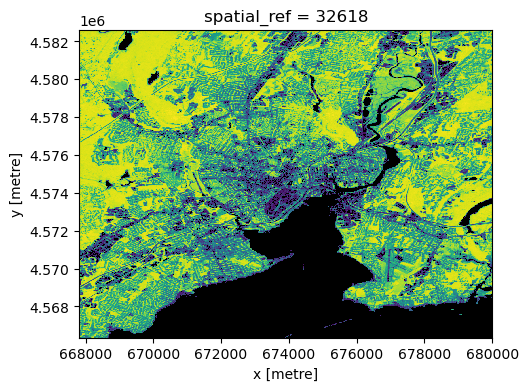

In [11]:
import matplotlib as plt
cmap = plt.colormaps.get_cmap('viridis')  # viridis is the default colormap for imshow
cmap.set_bad(color='black')

ndvi.plot.imshow( cmap=cmap, add_colorbar=False, size=4)

To visualize our dervied data on an interactive map or share it with other researchers, we need to be able to export it to a file.  One of the best choices for this purpose is a format referred to as "Cloud Optimized GeoTiff", or "COG" for short.  A COG file embeds multiple "zooms" and internal tiles, allowing it be rendered rapidly in visualizations.  COG data files still preserve the numerical values of each pixel and associated metadata, making them useful for further computations.  We will take advantage of this latter feature in seeking to summarize the average greeness in each polygon in our redlining data.  

In [29]:
import rioxarray
(ndvi
 .rio.reproject("EPSG:4326")
 .rio.to_raster(raster_path="ndvi.tif", 
                driver="COG")   
)


We can also store a copy of our vector data. 

In [19]:
# city.to_file("new_haven.shp") # common legacy format, not ideal
# city.to_file("new_haven.gpkg") # Good open standard

# latest option, best performance but less widely known:
city.to_parquet("new_haven.parquet")


In [7]:
from exactextract import exact_extract



Signature:
exact_extract(
    rast,
    vec,
    ops,
    *,
    weights=None,
    include_cols=None,
    include_geom=False,
    strategy: str = 'feature-sequential',
    max_cells_in_memory: int = 30000000,
    grid_compat_tol: float = 0.001,
    output: str = 'geojson',
    output_options: Optional[Mapping] = None,
    progress=False,
)
Docstring:
Calculate zonal statistics.

Args:
   rast: A :py:class:`RasterSource` or filename that can be opened
         by GDAL/rasterio/xarray.
   vec: A :py:class:`FeatureSource` or filename that can be opened
         by GDAL/fiona
   ops: A list of :py:class:`Operation` objects, or strings that
        can be used to construct them (e.g., ``"mean"``, ``"quantile(q=0.33)"``).
        Check out :doc:`Available operations </operations>` for more information.
   weights: An optional :py:class:`RasterSource` or filename for
        weights to be used in weighted operations.
   include_cols: An optional list of columns from the
        input features

In [18]:


city_stats = exact_extract("ndvi.tif", 
                           "new_haven.parquet", 
                           ["mean", "min", "max"], 
                           include_geom = True,
                           include_cols=["label", "city", "fill"],
                           output="pandas")
